### Reproducibility

In [1]:
# Code block generated with Gemini; prompt "All seeds needed for reproducibility in pytorch based DL project"

import os
import random
import numpy as np
import torch

def set_all_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

set_all_seeds(42)

### Data Exploration

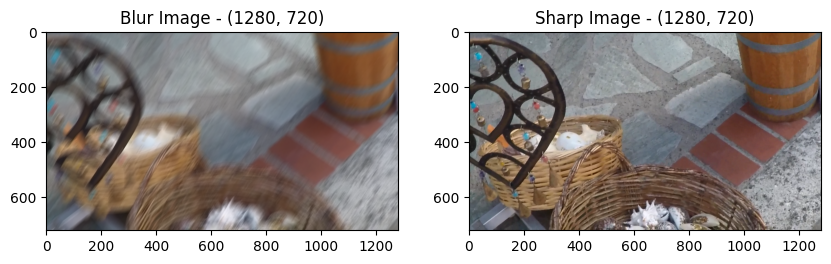

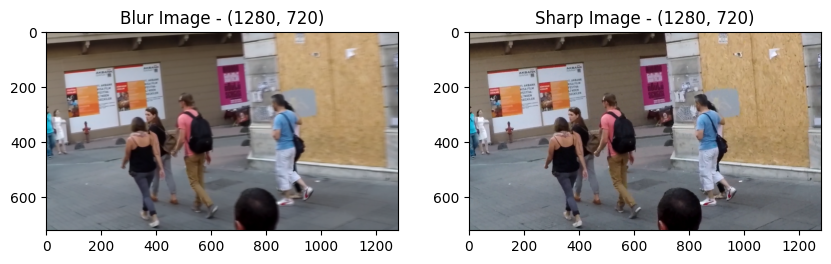

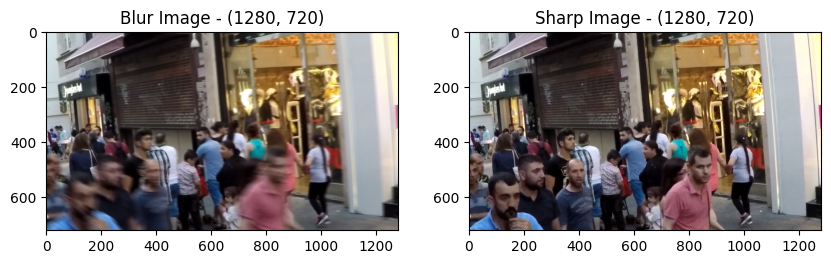

Total blur images: 1029
Total sharp images: 1029


In [2]:
from PIL import Image
import random, os
import matplotlib.pyplot as plt

root_dir = "gopro_deblur/"

def choose_and_plot_random_blur_and_unblur(root_dir):
    selected_blur_file = random.choice(os.listdir(os.path.join(root_dir, "blur/images")))
    blur_image_filename = os.path.join(root_dir, "blur/images", selected_blur_file)
    sharp_image_filename = os.path.join(root_dir, "sharp/images", selected_blur_file)
    # print(blur_image_filename, sharp_image_filename)
    blur_image = Image.open(blur_image_filename)
    sharp_image = Image.open(sharp_image_filename)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(blur_image)
    axs[1].imshow(sharp_image)

    axs[0].set_title(f'Blur Image - {blur_image.size}')
    axs[1].set_title(f'Sharp Image - {sharp_image.size}')
    plt.show()



choose_and_plot_random_blur_and_unblur(root_dir)
choose_and_plot_random_blur_and_unblur(root_dir)
choose_and_plot_random_blur_and_unblur(root_dir)

print(f"Total blur images: {len(os.listdir(os.path.join(root_dir, 'blur/images')))}")
print(f"Total sharp images: {len(os.listdir(os.path.join(root_dir, 'sharp/images')))}")

- ### All images are 1280x720 in size and there are 1029 images in both categories

### Trying to quantify BLUR-ness with FFT operator
- This lets us extract images with high blur, medium blur and low blur
- Ratio between high frequency and low frequency tells us how much blur is there in the image.

NOTE: This method works much better for motion-blur, while laplacian works much better for out-of-focus blur.

In [3]:
import cv2
from tqdm import tqdm
import numpy as np

def calculate_blur_score_fft(input_data, radius=30):
    if isinstance(input_data, str):
        img = cv2.imread(input_data, 0)
    else:
        if len(input_data.shape) == 3:
                # Handle float (0-1) vs uint8 (0-255)
                if input_data.dtype != np.uint8:
                    input_data = (input_data * 255).astype(np.uint8)
                img = cv2.cvtColor(input_data, cv2.COLOR_RGB2GRAY)
        else:
            img = input_data
    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft) # this function helps shift all the zero freq points to centre
    magnitude_spectrum = np.abs(dft_shift)
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, -1)
    low_freq_area = magnitude_spectrum * mask
    high_freq_area = magnitude_spectrum * (1 - mask)
    low_energy = np.sum(low_freq_area)
    high_energy = np.sum(high_freq_area)
    ratio = high_energy / low_energy
    return ratio

root_dir = "/home/nam/projects/sid/Motion-Deblurring/gopro_deblur/blur/images"
image_and_blur_score = []

for file in tqdm(os.listdir(root_dir)):
    full_path = os.path.join(root_dir, file)
    blur_score = calculate_blur_score_fft(full_path).item()
    image_and_blur_score.append([full_path, round(blur_score, 3)])

# Sorting in descending order according to blur_score, so that we can then split this into buckets of low, medium and high
# A high ratio means the image is sharp
sorted_blur_scores = sorted(image_and_blur_score, key=lambda x: x[1], reverse=True)

  0%|          | 2/1029 [00:00<01:07, 15.27it/s]

100%|██████████| 1029/1029 [00:59<00:00, 17.24it/s]


### Plotting Most Blur, Mid Blur and Least Blur

343 343 343


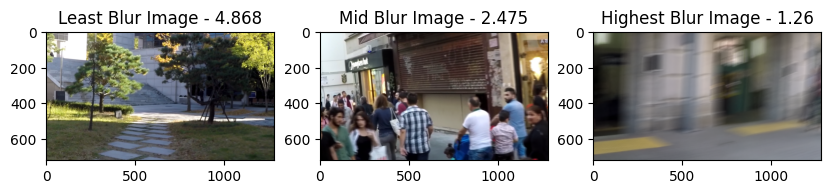

In [4]:
low_idx = len(sorted_blur_scores)//3
mid_idx = (len(sorted_blur_scores)*2)//3
high_idx = len(sorted_blur_scores)

low_blur_bucket, mid_blur_bucket, high_blur_bucket = sorted_blur_scores[:low_idx], sorted_blur_scores[low_idx:mid_idx], sorted_blur_scores[mid_idx:high_idx]
print(len(low_blur_bucket), len(mid_blur_bucket), len(high_blur_bucket))

low_blur_sample = low_blur_bucket[0]
mid_blur_sample = mid_blur_bucket[110]
high_blur_sample = high_blur_bucket[-1]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(Image.open(low_blur_sample[0]))
axs[1].imshow(Image.open(mid_blur_sample[0]))
axs[2].imshow(Image.open(high_blur_sample[0]))

axs[0].set_title(f'Least Blur Image - {low_blur_sample[1]}')
axs[1].set_title(f'Mid Blur Image - {mid_blur_sample[1]}')
axs[2].set_title(f'Highest Blur Image - {high_blur_sample[1]}')
plt.show()

### Plotting random samples from all 3 buckets

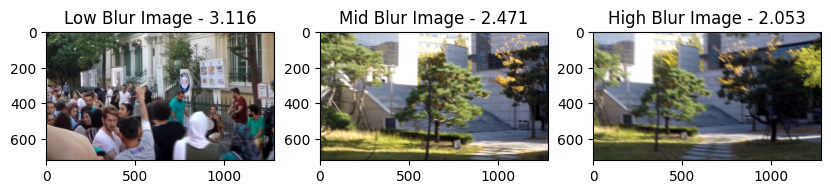

In [5]:
low_blur_sample = random.choice(low_blur_bucket)
mid_blur_sample = random.choice(mid_blur_bucket)
high_blur_sample = random.choice(high_blur_bucket)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(Image.open(low_blur_sample[0]))
axs[1].imshow(Image.open(mid_blur_sample[0]))
axs[2].imshow(Image.open(high_blur_sample[0]))

axs[0].set_title(f'Low Blur Image - {low_blur_sample[1]}')
axs[1].set_title(f'Mid Blur Image - {mid_blur_sample[1]}')
axs[2].set_title(f'High Blur Image - {high_blur_sample[1]}')
plt.show()

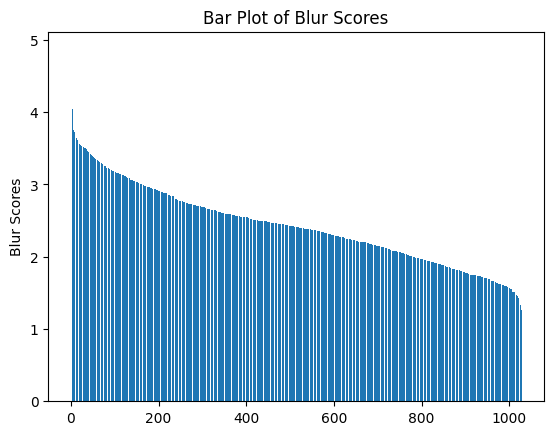

In [6]:
import matplotlib.pyplot as plt
import numpy as np

blur_scores_for_plot = [score[1] for score in sorted_blur_scores]
y_pos = np.arange(len(blur_scores_for_plot))
plt.bar(y_pos, blur_scores_for_plot)
plt.ylabel("Blur Scores")
plt.title("Bar Plot of Blur Scores")
plt.show()

### Wiener Filtering to see its effect on blur scores

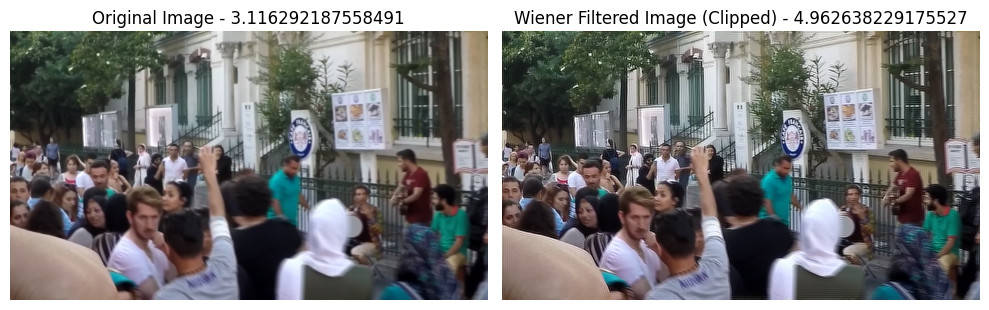

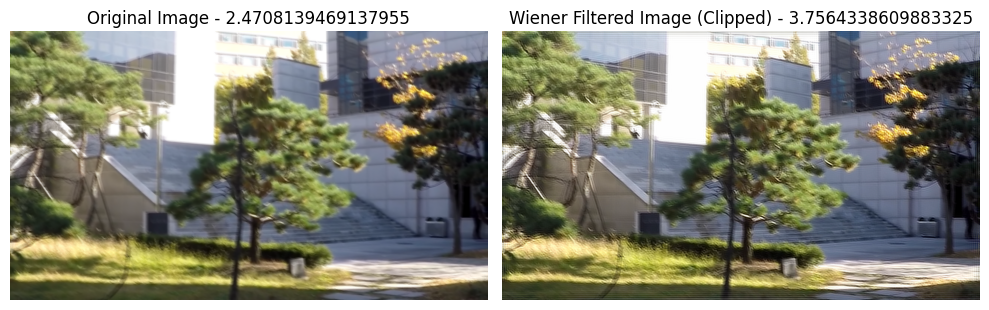

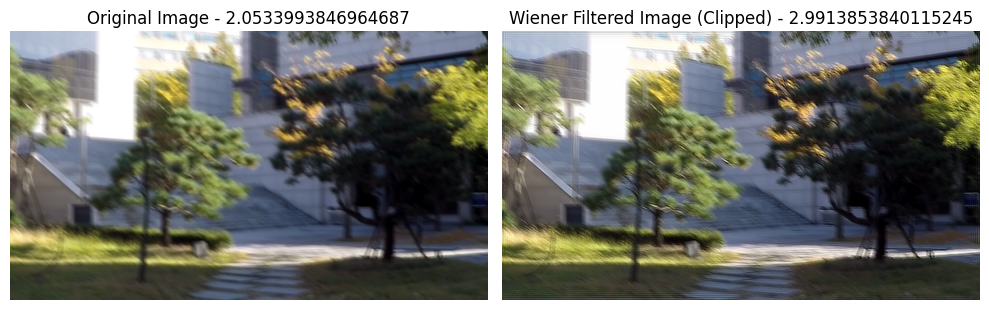

100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


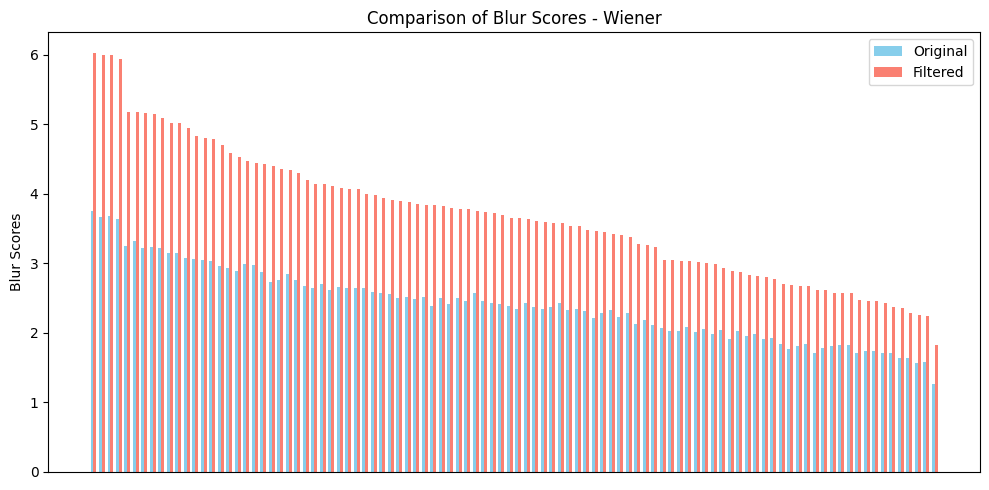

--- Blur Score Statistics ---
Average Original Score:  2.41
Average Filtered Score:  3.68
Average Absolute Increase: 1.27
Average Percentage Increase: 52.86%
Highest single image improvement: 2.33


In [9]:
import numpy as np
from skimage import restoration
import io
from scipy.signal import convolve2d
import matplotlib.pyplot as plt


def wiener_filtering_each_channel(blur_image_path, plot=False):
    original_blur_score = calculate_blur_score_fft(blur_image_path)
    blur_image = Image.open(blur_image_path)
    blur_image = np.array(blur_image) / 255.0
    psf = np.ones((5, 5)) / 25
    deconvolved_img = np.zeros_like(blur_image)
    
    for i in range(3):
        deconvolved_img[:, :, i] = restoration.wiener(blur_image[:, :, i], psf, balance=0.01)

    deconvolved_img = np.clip(deconvolved_img, 0, 1)
    filtered_blur_score = calculate_blur_score_fft(deconvolved_img)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        ax = axes.ravel()

        ax[0].imshow(blur_image)
        ax[0].set_title(f"Original Image - {original_blur_score}")
        ax[0].axis('off')

        ax[1].imshow(deconvolved_img)
        ax[1].set_title(f"Wiener Filtered Image (Clipped) - {filtered_blur_score}")
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()
    return deconvolved_img, original_blur_score, filtered_blur_score

wiener_filtering_each_channel(low_blur_sample[0], plot=True)
wiener_filtering_each_channel(mid_blur_sample[0], plot=True)
wiener_filtering_each_channel(high_blur_sample[0], plot=True)

image_and_blur_score = []
list_of_files = os.listdir("/home/nam/projects/sid/Motion-Deblurring/gopro_deblur/blur/images")
random.shuffle(list_of_files)
for image_file in tqdm(list_of_files[:100]):
    full_path = os.path.join("/home/nam/projects/sid/Motion-Deblurring/gopro_deblur/blur/images", image_file)
    deblurred_img, original_score, filtered_blur_score = wiener_filtering_each_channel(full_path)
    image_and_blur_score.append([full_path, original_score, filtered_blur_score])
    sorted_blur_scores = sorted(image_and_blur_score, key=lambda x: x[2], reverse=True)

original_blur_scores_for_plot = [score[1] for score in sorted_blur_scores]
blur_scores_for_plot = [score[2] for score in sorted_blur_scores]

x = np.arange(len(original_blur_scores_for_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, original_blur_scores_for_plot, width, label='Original', color='skyblue')
rects2 = ax.bar(x + width/2, blur_scores_for_plot, width, label='Filtered', color='salmon')

ax.set_ylabel("Blur Scores")
ax.set_title("Comparison of Blur Scores - Wiener")
ax.legend()
ax.set_xticks([])

plt.tight_layout()
plt.show()

differences = np.array(blur_scores_for_plot) - np.array(original_blur_scores_for_plot)
avg_increase = np.mean(differences)

avg_original = np.mean(np.array(original_blur_scores_for_plot))
percent_increase = (avg_increase / avg_original) * 100

print(f"--- Blur Score Statistics ---")
print(f"Average Original Score:  {avg_original:.2f}")
print(f"Average Filtered Score:  {np.mean(blur_scores_for_plot):.2f}")
print(f"Average Absolute Increase: {avg_increase:.2f}")
print(f"Average Percentage Increase: {percent_increase:.2f}%")

best_improvement = np.max(differences)
print(f"Highest single image improvement: {best_improvement:.2f}")

### So very clearly the filtering works as we can see the fourier ratio of high to low frequencies go up

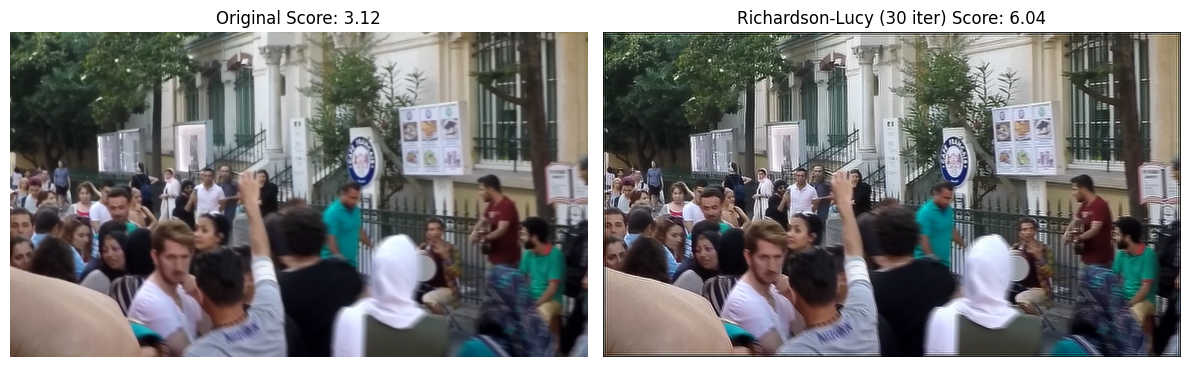

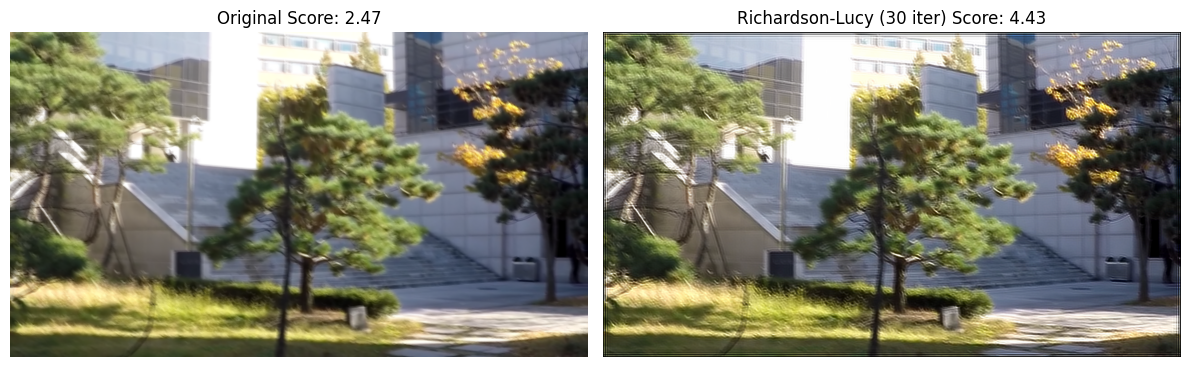

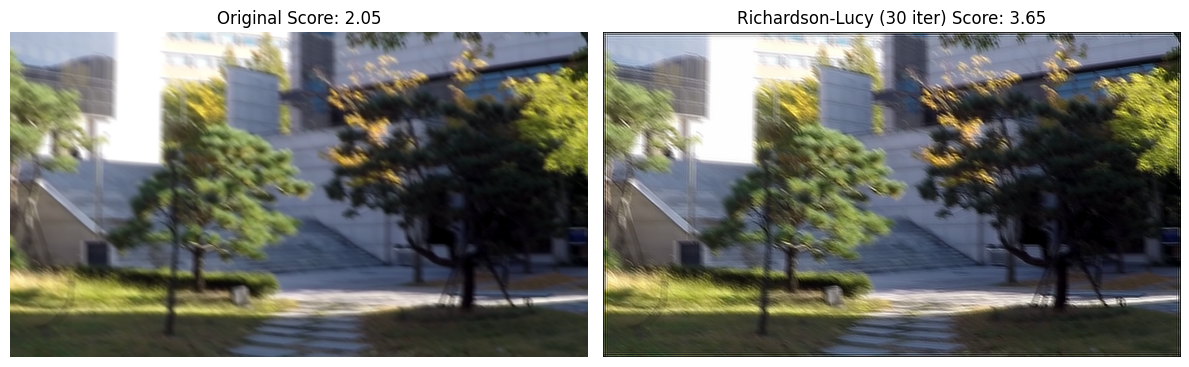

100%|██████████| 100/100 [08:22<00:00,  5.03s/it]


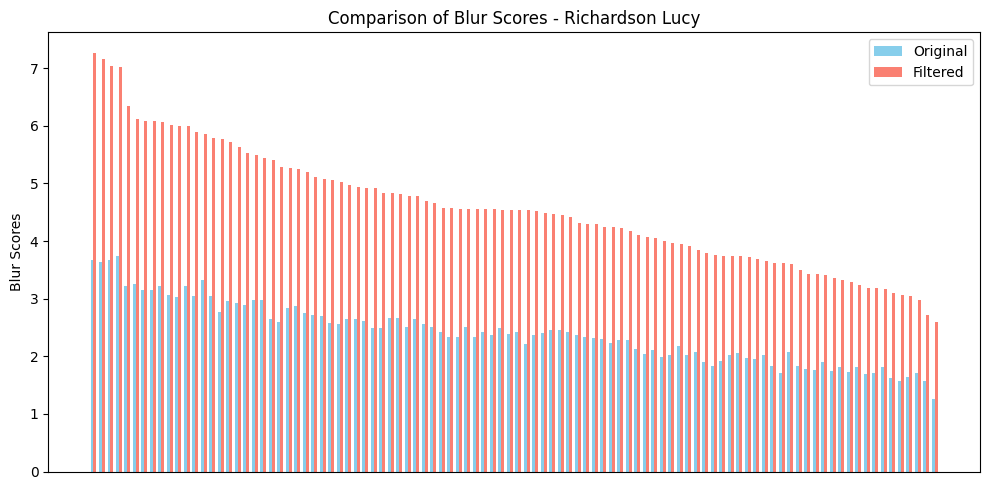

--- Blur Score Statistics ---
Average Original Score:  2.41
Average Filtered Score:  4.57
Average Absolute Increase: 2.16
Average Percentage Increase: 89.69%
Highest single image improvement: 3.59


In [11]:
import numpy as np
from skimage import restoration
from PIL import Image
import matplotlib.pyplot as plt

def richardson_lucy_filtering_each_channel(blur_image_path, iterations=30, plot=False):
    original_blur_score = calculate_blur_score_fft(blur_image_path)
    blur_image = Image.open(blur_image_path)
    blur_image = np.array(blur_image) / 255.0
    psf = np.ones((5, 5)) / 25
    
    deconvolved_img = np.zeros_like(blur_image)
    
    for i in range(3):
        # Richardson-Lucy deconvolution
        deconvolved_img[:, :, i] = restoration.richardson_lucy(
            blur_image[:, :, i], 
            psf, 
            num_iter=iterations
        )
    deconvolved_img = np.clip(deconvolved_img, 0, 1)
    filtered_blur_score = calculate_blur_score_fft(deconvolved_img)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        ax = axes.ravel()

        ax[0].imshow(blur_image)
        ax[0].set_title(f"Original Score: {original_blur_score:.2f}")
        ax[0].axis('off')

        ax[1].imshow(deconvolved_img)
        ax[1].set_title(f"Richardson-Lucy ({iterations} iter) Score: {filtered_blur_score:.2f}")
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()

    return deconvolved_img, original_blur_score, filtered_blur_score


richardson_lucy_filtering_each_channel(low_blur_sample[0], plot=True)
richardson_lucy_filtering_each_channel(mid_blur_sample[0], plot=True)
richardson_lucy_filtering_each_channel(high_blur_sample[0], plot=True)

image_and_blur_score = []
for image_file in tqdm(list_of_files[:100]):
    full_path = os.path.join("/home/nam/projects/sid/Motion-Deblurring/gopro_deblur/blur/images", image_file)
    deblurred_img, original_score, filtered_blur_score = richardson_lucy_filtering_each_channel(full_path)
    image_and_blur_score.append([full_path, original_score, filtered_blur_score])
    sorted_blur_scores = sorted(image_and_blur_score, key=lambda x: x[2], reverse=True)

original_blur_scores_for_plot = [score[1] for score in sorted_blur_scores]
blur_scores_for_plot = [score[2] for score in sorted_blur_scores]

x = np.arange(len(original_blur_scores_for_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, original_blur_scores_for_plot, width, label='Original', color='skyblue')
rects2 = ax.bar(x + width/2, blur_scores_for_plot, width, label='Filtered', color='salmon')
ax.set_ylabel("Blur Scores")
ax.set_title("Comparison of Blur Scores - Richardson Lucy")
ax.legend()
ax.set_xticks([])

plt.tight_layout()
plt.show()

differences = np.array(blur_scores_for_plot) - np.array(original_blur_scores_for_plot)
avg_increase = np.mean(differences)

avg_original = np.mean(np.array(original_blur_scores_for_plot))
percent_increase = (avg_increase / avg_original) * 100

print(f"--- Blur Score Statistics ---")
print(f"Average Original Score:  {avg_original:.2f}")
print(f"Average Filtered Score:  {np.mean(blur_scores_for_plot):.2f}")
print(f"Average Absolute Increase: {avg_increase:.2f}")
print(f"Average Percentage Increase: {percent_increase:.2f}%")

best_improvement = np.max(differences)
print(f"Highest single image improvement: {best_improvement:.2f}")

### By just looking at the ratios we can see the blur has definitely reduced(Since value of ratio has gone up). But the thing is motion blur still seems quite hard to solve with classical methods. Both deblurrings have reduced out-of-focus blur much better than motion-based-blur. The `richardson_lucy` is extremely slow as it is iterative. Initially only running for 100 images to see how the results look.

- ### We can try a deep learning based method to see if that fares any better
- I will be trying the `google/maxim-s3-deblurring-gopro` model directly from huggingface code

NOTE: The following code is taken from `kaggle` and is NOT my code, but i have made the required modifications.

I have downloaded the model from the same link given below and using it locally.
> Link for original code: https://www.kaggle.com/code/kerneler/inference-with-maxim-models

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

def get_model(model_url: str, input_resolution: tuple) -> tf.keras.Model:
    inputs = tf.keras.Input((*input_resolution, 3))
    hub_module = hub.KerasLayer(model_url)

    outputs = hub_module(inputs)

    return tf.keras.Model(inputs, outputs)


input_resolution = (256, 256)
model_handle = "/home/nam/projects/sid/Motion-Deblurring/google_deblur_model"
print(f"TF-Hub handle: {model_handle}.")


model = get_model(model_handle, input_resolution)

2026-02-26 17:42:13.481470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-26 17:42:13.596869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nam/miniconda3/envs/diff/lib/python3.10/site-packages/cv2/../../lib64:
2026-02-26 17:42:13.596893: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2026-02-26 17:42:13.615326: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

TF-Hub handle: /home/nam/projects/sid/Motion-Deblurring/google_deblur_model.


2026-02-26 17:42:18.604771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nam/miniconda3/envs/diff/lib/python3.10/site-packages/cv2/../../lib64:
2026-02-26 17:42:18.604843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nam/miniconda3/envs/diff/lib/python3.10/site-packages/cv2/../../lib64:
2026-02-26 17:42:18.604905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nam/miniconda3/envs/diff/lib/python3.10/site-packages/cv2/../../lib64:
2026-02-26 17:42:18.604950: W

100%|██████████| 100/100 [04:53<00:00,  2.93s/it]


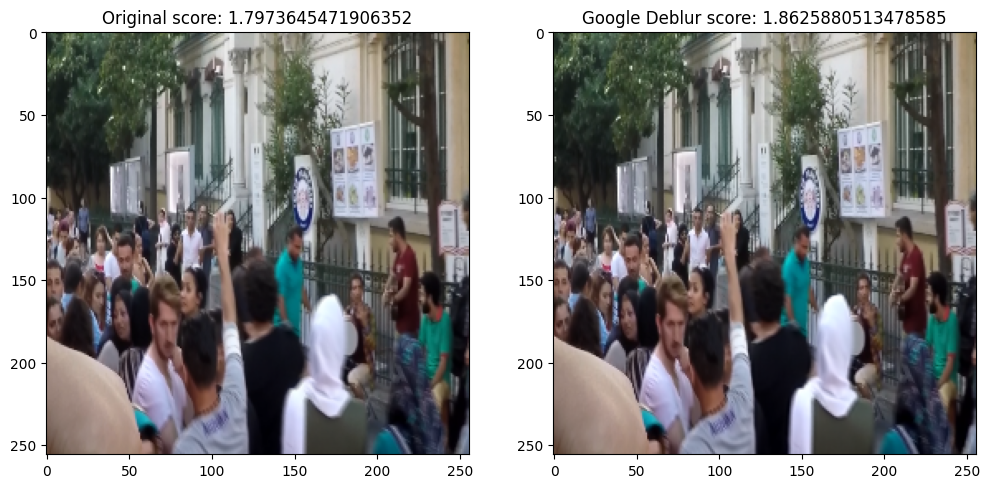

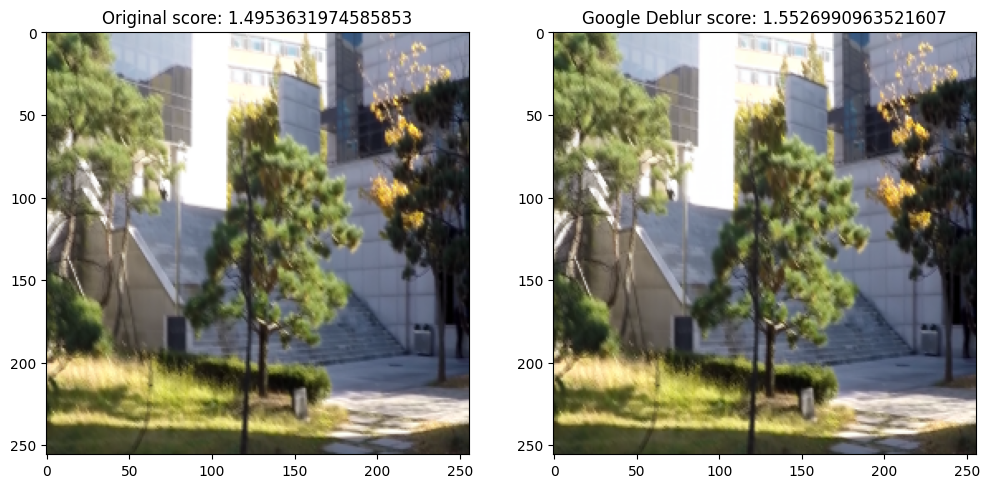

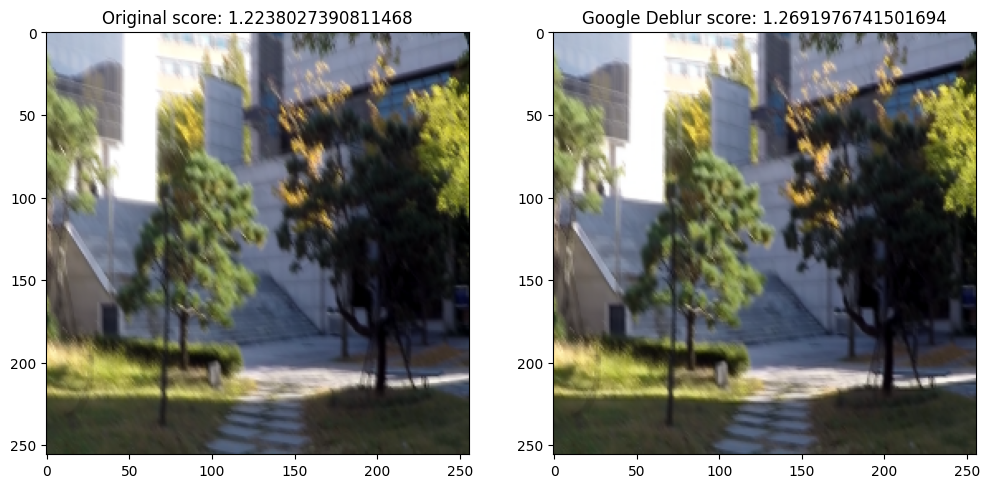

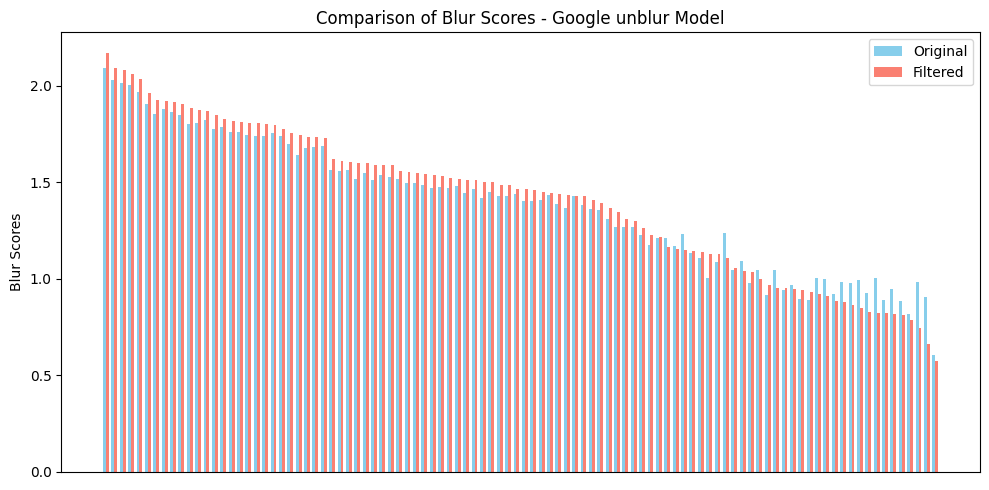

--- Blur Score Statistics ---
Average Original Score:  1.39
Average Filtered Score:  1.41
Average Absolute Increase: 0.02
Average Percentage Increase: 1.37%
Highest single image improvement: 0.12


In [13]:
def resize_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes `target_dim`.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, (target_dim, target_dim))
    return image


def process_image(image_path, target_dim=256):
    input_img = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
    input_img = tf.expand_dims(input_img, axis=0)
    input_img = resize_image(input_img, target_dim)
    return input_img

# Based on https://github.com/google-research/maxim/blob/main/maxim/run_eval.py
def infer(image_path: str, model: tf.keras.Model, input_resolution=(256, 256)):
    preprocessed_image = process_image(image_path, input_resolution[0])
    original_blur_score = calculate_blur_score_fft(preprocessed_image.numpy()[0])
    preds = model.predict(preprocessed_image, verbose=0)
    if isinstance(preds, list):
        preds = preds[-1]
        if isinstance(preds, list):
            preds = preds[-1]

    preds = np.array(preds[0], np.float32)
    final_pred_image = np.array((np.clip(preds, 0.0, 1.0)).astype(np.float32))
    final_blur_score = calculate_blur_score_fft(final_pred_image)
    return final_pred_image, original_blur_score, final_blur_score, preprocessed_image.numpy()[0]

def use_google_model_hf(image_path, plot=False):
    final_pred_image, score1, score2, ip_image = infer(image_path, model, input_resolution)
    def imshow(image, title=None):
        if len(image.shape) > 3:
            image = tf.squeeze(image, axis=0)

        plt.imshow(image)
        if title:
            plt.title(title)

    if plot:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        imshow(ip_image, f"Original score: {score1}")

        plt.subplot(1, 2, 2)
        imshow(final_pred_image, f"Google Deblur score: {score2}")
    return final_pred_image, score1, score2

use_google_model_hf(low_blur_sample[0], plot=True)
use_google_model_hf(mid_blur_sample[0], plot=True)
use_google_model_hf(high_blur_sample[0], plot=True)


image_and_blur_score = []
for image_file in tqdm(list_of_files[:100]):
    full_path = os.path.join("/home/nam/projects/sid/Motion-Deblurring/gopro_deblur/blur/images", image_file)
    deblurred_img, original_score, filtered_blur_score = use_google_model_hf(full_path)
    image_and_blur_score.append([full_path, original_score, filtered_blur_score])
    sorted_blur_scores = sorted(image_and_blur_score, key=lambda x: x[2], reverse=True)

original_blur_scores_for_plot = [score[1] for score in sorted_blur_scores]
blur_scores_for_plot = [score[2] for score in sorted_blur_scores]

x = np.arange(len(original_blur_scores_for_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, original_blur_scores_for_plot, width, label='Original', color='skyblue')
rects2 = ax.bar(x + width/2, blur_scores_for_plot, width, label='Filtered', color='salmon')
ax.set_ylabel("Blur Scores")
ax.set_title("Comparison of Blur Scores - Google unblur Model")
ax.legend()
ax.set_xticks([])

plt.tight_layout()
plt.show()

differences = np.array(blur_scores_for_plot) - np.array(original_blur_scores_for_plot)
avg_increase = np.mean(differences)

avg_original = np.mean(np.array(original_blur_scores_for_plot))
percent_increase = (avg_increase / avg_original) * 100

print(f"--- Blur Score Statistics ---")
print(f"Average Original Score:  {avg_original:.2f}")
print(f"Average Filtered Score:  {np.mean(blur_scores_for_plot):.2f}")
print(f"Average Absolute Increase: {avg_increase:.2f}")
print(f"Average Percentage Increase: {percent_increase:.2f}%")

best_improvement = np.max(differences)
print(f"Highest single image improvement: {best_improvement:.2f}")

` We can see that there are some cases where our noise ratio goes up. The magnitude of the ratio is much lower than the previous 2 de-blurring methods. This is because the images are resized to 256x256x3 and not processed in the native resolution of 1280x720x3. The number of pixels processed is significantly lesser here and thats why the score is also significantly smaller.`

> So we will look at the avg change in score in all 3 methods to see which one gives us the most amount of noise removal.